<div align='center'><b> Navigation Project - Banana Collector using DRL</b> </div>

<img src='https://s3.amazonaws.com/video.udacity-data.com/topher/2018/June/5b1ab4b0_banana/banana.gif'>

<p> For this project, it's trained an agent to navigate (and collect bananas!) in a large, square world. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

    0 - move forward.
    1 - move backward.
    2 - turn left.
    3 - turn right.

The task is episodic, and in order to solve the environment, your agent must get an average score of +13 over 100 consecutive episodes.</p>

In [2]:
# install packages neccesary for the environment
!pip -q install ./python

In [3]:
# import packages this project
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
from collections import deque
import matplotlib.pyplot as plt

In [4]:
# hyperparameters for my network 
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.99            
TAU = 1e-3              
LR = 5e-4               
UPDATE_EVERY = 4        

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# QNetwork class
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
"""
    Agent class: it's job is to interact whith the environment
    and learn proper actions to maximise it's reward
"""
class Agent():
    def __init__(self, state_size, action_size, seed, filename=None):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        if filename:
            weights = torch.load(filename)
            self.qnetwork_local.load_state_dict(weights)
            self.qnetwork_target.load_state_dict(weights)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_t_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_t = rewards + (gamma * Q_t_next * (1 - dones))  
        Q_e = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_e, Q_t)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

            
            
"""
    ReplayBuffer class, adds and stores experience in form of tuples
"""
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [7]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [8]:
"""
 DQN learns a policy, which tells an agent what action to take under what circumstances.
"""

def dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.0001, eps_decay=0.97, train=True):
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps if train else 0.0)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]                  
            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward                                
            state = next_state                             
            if done:                                       
                break
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0 and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_dqn.pth')
            break
    return scores

Episode 100	Average Score: 1.04
Episode 200	Average Score: 4.45
Episode 300	Average Score: 7.00
Episode 400	Average Score: 9.60
Episode 467	Average Score: 13.06
Environment solved in 367 episodes!	Average Score: 13.06


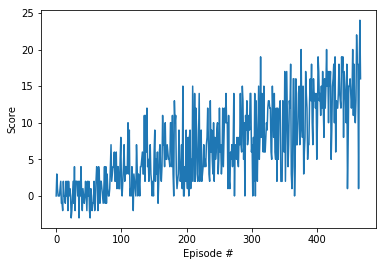

In [9]:
# training and plots the scores
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = dqn(agent)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, filename='checkpoint_dqn.pth')
scores = dqn(agent, n_episodes=100, train=False)

Episode 100	Average Score: 11.49


In [ ]:
env.close()